# **P8 - Assurez une veille technique**

## **Sommaire**

1. [Import](#Import)  
2. [Jeu de données](#Jeu-de-données)    
3. [Méthodes NLP avancées](#Méthodes-NLP-avancées)
    1. [BERT](#BERT)  
    2. [LoRA](#LoRA)
    3. [Feature importance](#Feature-importance)

## **Import**

In [1]:
import torch
print(torch.__version__)
print("GPU dispo :", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.1.0+cu118
GPU dispo : True
GeForce RTX 3060 Laptop GPU


In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import cv2
import os
import torch
import zipfile

import sklearn
import tensorflow as tf
import torchvision
import tensorflow_hub as hub
import matplotlib
import PIL
import torchvision.transforms as transforms

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from torchvision import models
from PIL import Image
from transformers import AutoTokenizer, AutoModel

# Affichage des versions
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"NLTK: {nltk.__version__}")
print(f"Gensim: {gensim.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Hub: {hub.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")

# Vérification des modules transformers
try:
    import transformers
    print(f"Transformers: {transformers.__version__}")
except ImportError:
    print("Transformers n'est pas installé.")

# Vérification de l'installation de NLTK Stopwords
try:
    stopwords.words("english")
    print("NLTK stopwords disponibles.")
except LookupError:
    print("Téléchargement des stopwords NLTK...")
    nltk.download("stopwords")

# Vérification de WordNet Lemmatizer
try:
    WordNetLemmatizer()
    print("NLTK WordNet Lemmatizer disponible.")
except LookupError:
    print("Téléchargement de WordNet pour NLTK...")
    nltk.download("wordnet")


C:\Users\guill\OneDrive\Documents\OpenClassroom\envs\pytorch_clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Pandas: 2.2.3
Numpy: 1.26.4
NLTK: 3.9.1
Gensim: 4.3.3
Scikit-learn: 1.6.1
Matplotlib: 3.10.1
OpenCV: 4.11.0
PyTorch: 2.1.0+cu118
TensorFlow: 2.19.0
TensorFlow Hub: 0.16.1
torchvision: 0.16.0+cu118
Pillow (PIL): 11.1.0
Transformers: 4.50.2
NLTK stopwords disponibles.
NLTK WordNet Lemmatizer disponible.


## **Jeu de données**

Nous allons reprendre le jeu de données utiliser lors du projet 6. Commençons par répeter les différentes opérations déjà effectuer.

In [2]:
# Télécharger les ressources nécessaires
nltk.download('stopwords')  
nltk.download('wordnet')    

# Charger les stopwords et initialiser le lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement des textes
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  
    tokens = text.split()  
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Nous pouvons à présent charger notre fichier

In [3]:
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# Vérifie les premières lignes pour voir les colonnes disponibles
print(df.head())

                            uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed Ki

In [4]:
df['cleaned_description'] = df['description'].apply(preprocess_text)

In [5]:
print(df[['description', 'cleaned_description']].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                 cleaned_description  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel 3 bat...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...  


In [6]:
# Extraire la catégorie principale
df['category'] = df['product_category_tree'].str.extract(r'\["([^>]+)')

# Vérifier les premières catégories extraites
print(df['category'].head())

0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
Name: category, dtype: object


## **Méthodes NLP avancées**

### BERT

Commençons par utiliser BERT. Il s'agit là du même résultat obtenu que lors du projet 6

In [31]:
# Charger le tokenizer et le modèle BERT en anglais
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

print("BERT model and tokenizer loaded successfully for English!")

BERT model and tokenizer loaded successfully for English!


In [15]:
# Fonction pour obtenir l'embedding BERT à partir d'un texte
def get_bert_embedding(text, tokenizer, model, max_length=128):
    
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True, 
        padding='max_length', 
        max_length=max_length
    )
    with torch.no_grad():
        outputs = model(**inputs)
    # Extraction de l'embedding du token [CLS]
    cls_embedding = outputs.last_hidden_state[:, 0, :]  
    return cls_embedding.squeeze().numpy()

In [16]:
embeddings = []
for text in df['cleaned_description']:
    emb = get_bert_embedding(text, tokenizer, model)
    embeddings.append(emb)
embeddings = np.array(embeddings)  

print("Dimension des embeddings BERT:", embeddings.shape)

Dimension des embeddings BERT: (1050, 768)


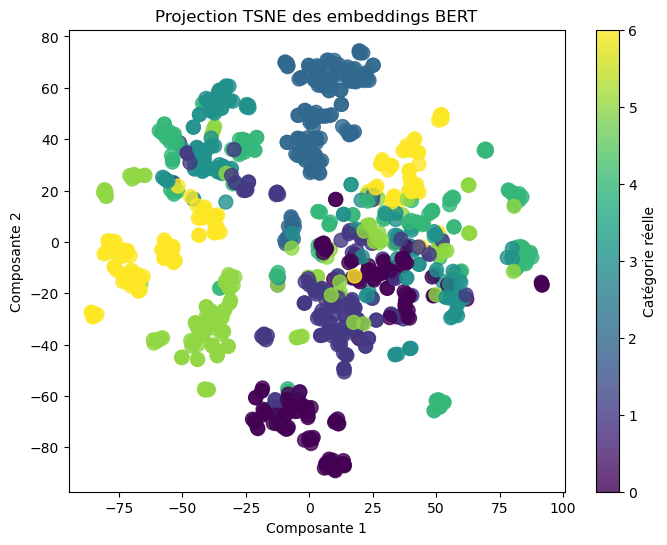

In [22]:
# Réduction de dimension avec TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5) 
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation de la projection en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=df['category'].factorize()[0], cmap='viridis', alpha=0.8, s=100)
plt.colorbar(scatter, label='Catégorie réelle')
plt.title("Projection TSNE des embeddings BERT")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

In [23]:
# Clustering et évaluation
n_clusters = df['category'].nunique()  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_2d)

# Ajout des clusters obtenus dans le DataFrame
df['cluster'] = clusters

# Évaluation de la similarité entre clusters et catégories réelles avec l'Adjusted Rand Index (ARI)
ari = adjusted_rand_score(df['category'], df['cluster'])

print("Adjusted Rand Index (ARI) :", ari)

Adjusted Rand Index (ARI) : 0.29750021830551404


### LoRA

Au tour de LoRA maintenant. L'objectif va donc d'utiliser BERT avec LoRA afin d'augmenter les performances de notre modèle.

In [8]:
pip install transformers datasets accelerate peft bitsandbytes


   ---------------------------------------- 0.0/75.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/75.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/75.4 MB 2.1 MB/s eta 0:00:36
    --------------------------------------- 1.0/75.4 MB 2.0 MB/s eta 0:00:37
    --------------------------------------- 1.6/75.4 MB 2.1 MB/s eta 0:00:36
   - -------------------------------------- 2.1/75.4 MB 2.1 MB/s eta 0:00:35
   - -------------------------------------- 2.6/75.4 MB 2.2 MB/s eta 0:00:33
   - -------------------------------------- 2.9/75.4 MB 2.2 MB/s eta 0:00:33
   - -------------------------------------- 3.7/75.4 MB 2.3 MB/s eta 0:00:32
   -- ------------------------------------- 3.9/75.4 MB 2.3 MB/s eta 0:00:31
   -- ------------------------------------- 4.5/75.4 MB 2.3 MB/s eta 0:00:31
   -- ------------------------------------- 5.0/75.4 MB 2.3 MB/s eta 0:00:31
   -- ------------------------------------- 5.5/75.4 MB 2.3 MB/s eta 0:00:31
   --- -----

L'objectif est d'entraîner un modèle de classification de texte à partir de descriptions de produits (cleaned_description) pour prédire leur catégorie (category). Pour cela, on utilise un modèle pré-entraîné BERT, que l'on adapte à notre tâche grâce à la méthode LoRA (Low-Rank Adaptation), une technique efficace pour fine-tuner de grands modèles avec peu de paramètres à ajuster.

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import torch

# Données
df_small = df[['cleaned_description', 'category']].dropna().reset_index(drop=True)
df_small['label'] = df_small['category'].factorize()[0]

# Dataset HuggingFace
dataset = Dataset.from_pandas(df_small[['cleaned_description', 'label']])

# Tokenization
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['cleaned_description'], padding='max_length', truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)

# Modèle + LoRA
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=df_small['label'].nunique())
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8, 
    lora_alpha=16, 
    lora_dropout=0.1, 
    bias="none"
)
model = get_peft_model(model, peft_config)

# Entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    per_device_train_batch_size=8,
    num_train_epochs=12,
    logging_dir='./logs',
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

trainer.train()

Map: 100%|████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 5440.92 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\guill\OneDrive\Documents\OpenClassroom\envs\pytorch_clean\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\guill\AppData\Local\Temp\ipykernel_10252\804423639.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftMode

Step,Training Loss
500,1.620900
1000,0.851400
1500,0.656100


TrainOutput(global_step=1584, training_loss=1.02149609845094, metrics={'train_runtime': 206.6078, 'train_samples_per_second': 60.985, 'train_steps_per_second': 7.667, 'total_flos': 831742926336000.0, 'train_loss': 1.02149609845094, 'epoch': 12.0})

Nous allons maintenant définir une fonction permettant d'extraire les embeddings de type CLS à partir d’un texte en utilisant le backbone BERT de notre modèle fine-tuné avec LoRA. Cette représentation est utile pour des tâches comme : la visualisation (PCA, t-SNE), le clustering, ou d'autres analyses sémantiques basées sur les textes.

In [8]:
def get_lora_embedding(text, tokenizer, model, max_length=128, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)  # s'assurer que le modèle est sur le bon device

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

    # déplacer les inputs sur le même device que le modèle
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model.bert(**inputs)  # Accès direct au backbone BERT
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    
    return cls_embedding.squeeze().cpu().numpy()  # on remet sur CPU pour numpy

In [9]:
lora_embeddings = np.array([get_lora_embedding(text, tokenizer, model) for text in df['cleaned_description']])

Maintenant passons à la réalisation graphique de la projection t-SNE des embeddings BERT + LoRA, ainsi qu'au calcule de l'ARI.

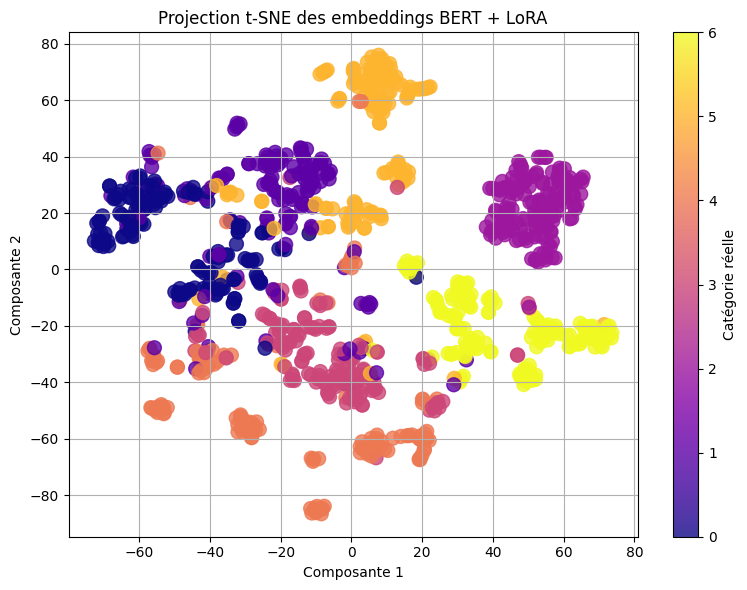

Adjusted Rand Index (ARI) avec BERT + LoRA : 0.5001


In [10]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
lora_embeddings_2d = tsne.fit_transform(lora_embeddings)

# Visualisation t-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    lora_embeddings_2d[:, 0],
    lora_embeddings_2d[:, 1],
    c=df['category'].factorize()[0],
    cmap='plasma',
    s=100,
    alpha=0.8
)
plt.colorbar(scatter, label='Catégorie réelle')
plt.title("Projection t-SNE des embeddings BERT + LoRA")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Clustering KMeans
n_clusters = df['category'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
lora_clusters = kmeans.fit_predict(lora_embeddings_2d)

# Évaluation avec l'ARI
df['lora_cluster'] = lora_clusters
ari_lora = adjusted_rand_score(df['category'], df['lora_cluster'])

print("Adjusted Rand Index (ARI) avec BERT + LoRA :", round(ari_lora, 4))

Comme nous pouvons le constater ici, les catégories sont mieux définies. De plus l'ARI obtenu avec cette méthode est bien supérieur à celle optenu précedemment. 

#### Feature importance

Plus qu'a déterminer la feature importance. 

In [21]:
pip install lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/12.8 MB 1.5 MB/s eta 0:00:09
   ---- ----------------------------------- 1.3/12.8 MB 1.7 MB/s eta 0:00:07
   ----- ---------------------------------- 1.8/12.8 MB 1.9 MB/s eta 0:00:06
   ------ --------------------------------- 2.1/12.8 MB 1.9 MB/s eta 0:00:06
   -------- ------------------------------- 2.6/12.8 MB 1.9 MB/s eta 0:00:06
   --------- ------------------------------ 2.9/12.8 MB 1.9 MB/s eta 0:00:06
   ---------- ----------------------------- 3.4/12.8 MB 1.9 MB/s eta 0:00:05
   ------------ --------------------------- 3.9/12.8 MB 1.9 MB/s eta 0:00:05
   ------------- -------------------------- 4.2/12.8 MB 2.0 MB/s 

Avant d’utiliser LIME pour interpréter les prédictions du modèle, nous devons définir une fonction predict_proba que LIME pourra appeler. Cette fonction doit : recevoir un ou plusieurs textes bruts (sous forme de liste), effectuer la tokenisation, passer les entrées dans le modèle, retourner les probabilités de prédiction sous forme de tableau NumPy.

In [11]:
# Le modèle doit être sur le bon device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Fonction que LIME peut appeler
def predict_proba(texts):
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.cpu().numpy()

Nous allons maintenant utiliser LIME pour interpréter les décisions de notre modèle BERT + LoRA sur une description de produit.
LIME va perturber légèrement le texte d’entrée, observer les effets sur la prédiction, et en déduire quels mots influencent le plus le modèle.

In [12]:
from lime.lime_text import LimeTextExplainer

# Mettre le modèle sur CPU pour éviter l'erreur CUDA
device = "cpu"
model = model.to(device)
model.eval()

# Fonction pour la prédiction 
def predict_proba(texts):
    inputs = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.cpu().numpy()

# Tronquer les textes trop longs à 50 mots
df['short_description'] = df['cleaned_description'].apply(lambda x: ' '.join(x.split()[:50]))

# LIME : création de l’explainer
class_names = df['category'].unique().tolist()
explainer = LimeTextExplainer(class_names=class_names)

# Sélection d’un exemple
i = 0  
text_to_explain = df['short_description'].iloc[i]

# Explication avec LIME 
exp = explainer.explain_instance(
    text_to_explain,
    predict_proba,
    num_features=5,        # top 5 tokens les plus influents
    num_samples=100        # moins de samples pour économiser la RAM
)

# Affichage interactif
exp.show_in_notebook(text=True)